# Quantifiying Media Bias on Cable News: BERT Slant Model

In this python notebook I explore quantifiying media bias on U.S. cable news. The idea is to quantify media bias in a very large corpus (≈6 million 1-minute broadcasts) of cable news broadcasts that I web scraped from the [TV Archive][1]. I do this using methods pioneered by Gentzkow and Shapiro (2010) but taking a more state-of-the-art approach in Natural Language Processing (NLP) by using the Transformer model BERT (Devlin et. al. 2018). Gentzkow and Shapiro (2010) measured media bias by learning the phrases of politicians that are the most predictive of politician's ideology. They then captured the use of these phrases in media outlets, the idea being that if a media outlet tends to use many phrases that are associated with conservative politicians, then that media outlet could perceived as being more conservative, or vice versa for liberal phrases and outlets. This measure of media bias is known as "slant". For example, it is well known (see Djourelova 2021) that when discussing the topic of immigrants that have arrived to the U.S. via non-legal routes, conservatives tend to refer to these immigrants as "illegal immigrants" or "illegals", whereas liberals tend to use the term "undocumented immigrants". Thus, when discussing this topic, if a media outlet features frequent use of terms like "illegals" or "illegal immigrant", then that outlet is probably a more conservative outlet. For more examples, see Gentzkow and Shapiro (2010).

I take this "slant" approach but use more state-of-the-art Transformer models because they are much more powerful than the methods used in Gentzkow and Shapiro (2010). This is because the architecture of Transformer models allows them to take into account important aspects of language, like context, that older methods were unable to capture and which have been shown to be important for models to understand natural language. In addition, these models are pre-trained on truly massive amounts of text, like the entirety of Wikipedia and the Google Books corpus, that makes them extremely powerful at understanding language out-of-the-box. The models can then be "fine-tuned" on a specific task, and have been shown to be far more performant on NLP tasks because they can transfer knowledge learned during the pre-training process to the task at hand.

Here, the task is to learn ideological language in speeches given by politicians in Congress, with the eventual goal of using the model to capture ideological language on cable news. The idea is to fine-tune the BERT model on a regression task using the text of speeches given by politicians in Congress and using the estimated ideology of the politicians giving the speeches as the target label. Thus, the model should learn the aspects of language that predict a politician's ideology. I do this in a few steps, with the easy to use [Simple Transformers][2] python library. Firstly, I continue the standard BERT pre-training task (known as language modeling) on my corpus of cable news text. This consists of masking random words ("tokens") in cable news text, and asking the model to predict the word. The code for this can be seen in scripts/1-preprocessing.py and scripts/2-media-pretraining.py. I then conduct a WandB sweep to tune the hyperparameters (learning rate and number of epochs) for the model, because this will prove important for the performance of the model. The code for this can be found in scripts/3-bertslant-sweep.py. I then train the model with these optimized hyperparameters (code in scripts/4-train-bertslant.py), with the model reaching an $R^2$ of 0.59, which I see as a very good level of performance. Lastly, I run this this model (code in scripts/5-slant-inference.py) on my corpus of cable news text, obtaining the predicted ideology scores of the cable news broadcasts.

With this measure of slant in hand, I then summarize slant by channel and show that according to this method, Fox News is the most right-wing channel, MSNBC is the most left-wing, and MSNBC is somewhere more in the middle. These results make sense and align with the literature, see for example Martin and Yurugoklu (2017). 



[1]: https://archive.org/details/tv
[2]: https://simpletransformers.ai/


Install and load in necessary packages

In [35]:
#!pip3 install pandas numpy seaborn wandb

import pandas as pd
import numpy as np
import seaborn as sns
import wandb
from pprint import pprint 

sns.set_theme(style="ticks")


Now we want to load in the data that was used to trained the BERT slant model. This data consists of speeches given by politicians during the 111th-114th Congresses (2009-2016) paired with information on the politicians' ideology. The speeches come from Gentzkow, Shapiro and Taddy (2019), who collected the data from the Congressional Record. They cleaned and parsed the speeches, making them far easier to work with. The politician ideology estimates come from Voteview.com. They estimate politician ideology based on observed voting behavior in Congress. Intuitively, if two politicians consistently vote similarly to one another, then they will be estimated to have a similar ideology. 

In [36]:
# load in the data
cong_ideology_training = pd.read_csv("raw-data/congressional_speeches_ideology.csv", encoding="ISO-8859-1")
# keep only speeches from the 111th to the 114th congresses (overlaps with sample period)
cong_ideology_training = cong_ideology_training[cong_ideology_training["congress"] >= 111]
# convert text to lower case
cong_ideology_training["speech"] = cong_ideology_training["speech"].apply(lambda x: x.lower())

Below we can see that we have a lot of information to go along with the speeches, including who the speaker was, which Congress the speech was given in, what their position in Congress is, their party, etc. At the end we find two estimates of the speaker's ideology, nominate_dim1 and nominate_dim2. We will focus on nominate_dim1, which is thought to correspond to the traditional "left-right" dimension of ideology. 

In [37]:
# get a selection of data for viewing
cong_ideology_training.sample(n=10, random_state=1)

,speakerid,speech_id,lastname,firstname,chamber,state,gender,party,district,nonvoting,speech,congress,sentence_count,bioguide_id,nominate_dim1,nominate_dim2
336843,114120961,1140096858,REID,HARRY,S,NV,M,D,NaN,voting,mr. president. it is not necessary to go into ...,114,127,R000146,-0.276,0.258
313296,113122390,1130092588,CRAMER,KEVIN,H,ND,M,R,0.0,voting,mr. speaker. in new town. north dakota. right ...,113,17,C001096,0.393,0.327
275910,113117441,1130003813,LEVIN,CARL,S,MI,M,D,NaN,voting,i thank my good friend from rhode island. who ...,113,127,L000261,-0.395,-0.116
186495,111115930,1110153004,OBEY,DAVID,H,WI,M,D,7.0,voting,again. as ive said. was my chairman and. as a ...,111,61,O000007,-0.450,-0.063
326608,114119510,1140054277,GARRETT,SCOTT,H,NJ,M,R,5.0,voting,mr. speaker. i yield myself the balance of my ...,114,12,G000548,0.688,-0.243
327449,114119620,1140077267,GREEN,AL,H,TX,M,D,9.0,voting,mr. speaker. in consuming this time. let me co...,114,11,G000553,-0.438,0.305
327227,114119591,1140051405,GRASSLEY,CHARLES,S,IA,M,R,NaN,voting,mr. president. the popes visit this week to ou...,114,78,G000386,0.349,-0.068
264838,112120751,1120092156,PAUL,RAND,S,KY,M,R,NaN,voting,the question i have for senate is. has your go...,112,52,P000603,0.877,-0.480
236504,112117441,1120014802,LEVIN,CARL,S,MI,M,D,NaN,voting,mr. president. the badly misguided budget cuts...,112,44,L000261,-0.395,-0.116
245826,112118381,1120116904,REED,JOHN,S,RI,M,D,NaN,voting,madam president. the agriculture reform. food....,112,44,R000122,-0.367,-0.172


Here we print one of the speeches given by one of the most conservative senators in Congress, Rand Paul: 

In [38]:
pprint("Rand Paul Ideology Score: " + str(cong_ideology_training["nominate_dim1"][264838]))
pprint(cong_ideology_training.speech[264838])

'Rand Paul Ideology Score: 0.877'
('the question i have for senate is. has your government gotten out of '
 'control? have the regulators become so numerous and so zealous that we cant '
 'even carry on the ordinary affairs of our government? we recently had a '
 'bridge where a boat ran into the bridge in kentucky and one could no longer '
 'cross the bridge because it is not there. we have to wait for environmental '
 'regulations and environmental studies. which sometimes can be 4 and 5 years. '
 'before we can repair our bridges and our roads during an emergency. this is '
 'crazy. this goes on even in regular affairs. such as trying to replace a '
 'sewage plant in our state or throughout the united states. do we want to '
 'live in a country where we have to stop and count how many barnacles are on '
 'our bridge before we decide whether to rebuild the bridge? do we want to '
 'stop and count how many mussels are attached to the pier before we rebuild '
 'the bridge? in the end w

And here is an example of a speech given by a famous liberal senator, Bernie Sanders: 

In [39]:
pprint("Bernie Sanders Ideology Score: " + str(cong_ideology_training["nominate_dim1"][202558]))
pprint(cong_ideology_training["speech"][202558])

'Bernie Sanders Ideology Score: -0.531'
('mr. president. soon we will be voting on the lilly ledbetter fair pay act. '
 's. 181. the house of representatives has already passed this legislation by '
 'a vote of 247 to 171. passing this bill today will send a clear message that '
 'our country will not tolerate unequal pay for equal work. as astonishing as '
 'it is. in the year 2009. women earn. on average. only 77 cents for every '
 'dollar earned by men in comparable jobs. what a truly unthinkable. and '
 'frankly disgraceful. circumstanceone that we must do everything within our '
 'power to change. today we have the opportunity to take a small but very '
 'significant step in making sure that americans have the legal opportunity to '
 'challenge pay discrimination. lilly ledbetter was a loyal employee at '
 'goodyear tire and rubber company for 19 years. at first. .her salary was in '
 'line with that of her male colleagues. but over time she got smaller raises '
 'creating a signi

Here we plot the distribution of nominate_dim1 in Congress, underlining the polarization and partisanship in Congress between liberal and conservative ideology. This is the source of variation that the model will attempt to learn to predict, given the words that politicians use in their speeches.

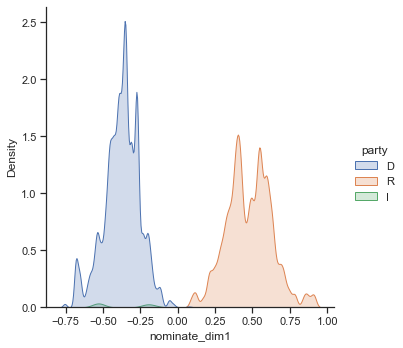

In [40]:
# plot the distribution of ideology in congress
sns.displot(cong_ideology_training, x="nominate_dim1", hue = "party", kind="kde", fill=True)

Next, I used this data to train the BERT model to recognize ideological speech. The "features" are the text of the speeches, and the target labels are the ideological scores. Because ideology is a continuous variable, the training task was a regression task (adding a final linear layer to the BERT model). To converge on a final model, I used WandB sweeps to tune the two most important hyperparameters of these models, the learning rate and the number of epochs. Because these models are very costly to train, I do not do this here. You can see the code for this in scripts/3-bertslant-sweep.py. The results from training these models on powerful cloud computing systems with GPUs on the UZH science cloud platform are presented below from WandB:

In [41]:
%wandb jacob-miller29/Slant%20Hyperparamater%20Optimization

After many runs of the model, I converged on a learning rate of 2e-05 and 3 epochs of training as the optimal hyperparameters in this setting. I then trained a model with these hyperparameters in scripts/4-train-bertslant-algorithm.py. The results are presented below. As we can see, the model reaches an $R^2$ of 0.59, meaning that given the text of speeches in the test set, the model can explain 59% of the variation in politician ideology. 

In [42]:
%wandb jacob-miller29/bert-slant

I then ran this model on my dataset of cable news broadcasts (≈6 million 1-minute broadcast segments) to get the predicted ideology scores of the media broadcasts. I load these results in, and merge them to some metadata so we can start to explore slant on the media. 

In [43]:
# load in the cable news slant scores as predicted from the BERT slant model
media_slant_scores = pd.read_csv("output-data/media-slant-scores.csv", usecols = ["id", "slant"])

# the ideology score was normalized to speed up training, now I undo this normalization to restore the original values
media_slant_scores["slant"] = media_slant_scores["slant"]*(0.913 + 0.757) - 0.757
# load in some meta data for the cable news segments
tv_archive_data = pd.read_csv("raw-data/tv-archive-data.csv", usecols = ["id", "date", "channel"])

# resolving some channel name issues
conditions = [
    tv_archive_data["channel"] == "FOXNEWSW",
    tv_archive_data["channel"] == "MSNBCW",
    tv_archive_data["channel"] == "CNNW"
]
choices = ["FOXNEWS", "MSNBC", "CNN"]
tv_archive_data["channel"] = np.select(conditions, choices)

# keep only cable news 
tv_archive_data = tv_archive_data[(tv_archive_data["channel"] == "FOXNEWS") | (tv_archive_data["channel"] == "MSNBC") | (tv_archive_data["channel"] == "CNN")]
# merge the meta data in
media_slant = media_slant_scores.merge(tv_archive_data, on="id", how="inner")

Here I plot the distribution of estimated slant by channel. As we can see, Fox News is the most right-wing channel, MSNBC is the most left-wing channel, and CNN is slightly more moderate. These results make sense, and are in line with what other papers in the literature have found. Thus we've made a first start at understanding media bias! 

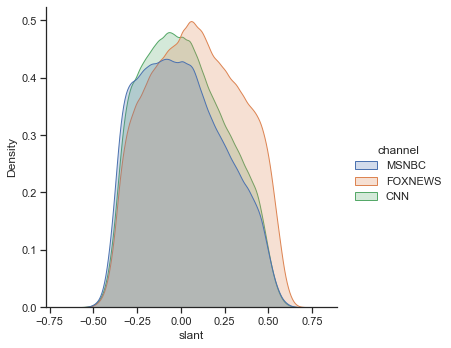

In [44]:
# plot the distribution of slant by channel
sns.displot(media_slant, x="slant", hue="channel", kind="kde", fill=True)

# References 

Devlin, Jacob, Ming Wei Chang, Kenton Lee, and Kristina Toutavnova. 2018. “BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.” *arXiv*: 1810.04805.

Djourelova, Milena. 2021. “Media Persuasion through Slanted Language: Evidence from the Coverage of Immigration.” *Working Paper*.

Gentzkow, Matthew, and Jesse M. Shapiro. 2010. “What Drives Media Slant: Evidence from U.S. Daily Newspapers.” *Econometrica*, 78(1): 35-71.

Gentzkow, Matthew, Jesse M. Shapiro, and Matt Taddy. 2019. “Measuring Group Differences in High-Dimensional Choices: Method and Application to Congressional Speech.” *Econometrica*, 87(4): 1307-1340.

Martin, Gregory J., and Ali Yurugoklu. 2017. “Bias in Cable News: Persuasion and Polarization.” *American Economic Review* 107(9): 2565-2599.